# Initialise 

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/non-hepato', verbose=1)

import logging

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)

In [2]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.minimal

In [3]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190722.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "non-hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [4]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [5]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [6]:
models = c14.models.minimal.models_list
models

[c14.models.minimal.A, c14.models.minimal.Aq]

In [7]:
init_limit = {'lambda_': (-3, 0), 
              'f': (1, 3)
             }

In [8]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

________________________________________________________________________________
[Memory] Calling __main__--home-fabrost-pksCloud-projects-C14_liver-source-fabian-python-__ipython-input__.fit_model...
fit_model(<c14.models.base.exp_data object at 0x7fcadb6234a8>, <class 'c14.models.minimal.A'>, 0.5, {'init_limit': {'f': (1, 3), 'lambda_': (-3, 0)}, 'n': 100, 'processes': 7})
Fitting model A
[(-3, 0)]
_______________________________________________________fit_model - 32.6s, 0.5min
________________________________________________________________________________
[Memory] Calling __main__--home-fabrost-pksCloud-projects-C14_liver-source-fabian-python-__ipython-input__.fit_model...
fit_model(<c14.models.base.exp_data object at 0x7fcadb6234a8>, <class 'c14.models.minimal.Aq'>, 0.5, {'init_limit': {'f': (1, 3), 'lambda_': (-3, 0)}, 'n': 100, 'processes': 7})
Fitting model Aq
[(1, 3), (-3, 0)]


/home/fabrost/pksCloud/projects/C14_liver/source/c14/c14/models/minimal.py:62: RuntimeWarning: invalid value encountered in arctanh
  p_fit['f'] = -np.arctanh(1 - 2*p_fit['f'])
/home/fabrost/pksCloud/projects/C14_liver/source/c14/c14/models/minimal.py:62: RuntimeWarning: divide by zero encountered in arctanh
  p_fit['f'] = -np.arctanh(1 - 2*p_fit['f'])


_______________________________________________________fit_model - 76.0s, 1.3min
CPU times: user 668 ms, sys: 101 ms, total: 768 ms
Wall time: 1min 48s


A


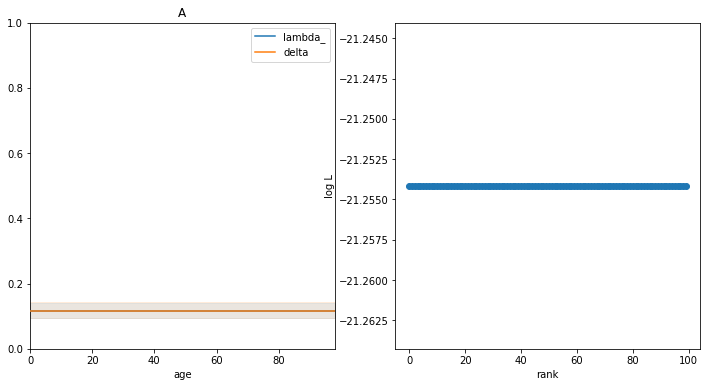

point_estimate      lower     upper
time parameter                                    
0    delta           0.115293  0.0945093  0.140231
     lambda_         0.115293  0.0938608  0.141618
80   delta           0.115293  0.0945093  0.140231
     lambda_         0.115293  0.0938608  0.141618

Aq


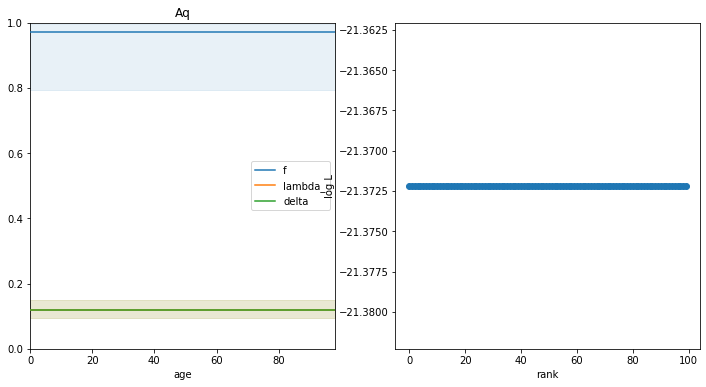

point_estimate      lower     upper
time parameter                                    
0    delta           0.118632  0.0944829  0.147172
     f               0.970445   0.792587  0.996468
     lambda_         0.118632  0.0945885  0.148787
80   delta           0.118632  0.0944829  0.147172
     f               0.970445   0.792587  0.996468
     lambda_         0.118632  0.0945885  0.148787

In [9]:
for name, result in results.items():
    print(name)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
    axs[0].legend()
    axs[0].set_title(name)
    axs[0].set_ylim(0,1)
    
    fval = result['multistart_result']['fval']
    axs[1].scatter(np.arange(len(fval)), fval.values)
    axs[1].set_xlabel('rank')
    axs[1].set_ylabel('log L')
    
    plt.show()
   
    display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 80]))

In [10]:
final_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
final_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for model, result in results.items()]
final_results['nparas'] = [result['model'].nparas for model, result in results.items()]
final_results = pd.DataFrame(final_results)
final_results['delta'] = final_results['cAIC'] - final_results['cAIC'].min() 
final_results['w'] = np.exp(-0.5*final_results['delta']) / np.exp(-0.5*final_results['delta']).sum()
final_results['ER'] = final_results['w'].max() / final_results['w']
final_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
A,-37.008295,21.254148,1,0.000000,0.863687,1.000000
Aq,-33.315782,21.372177,2,3.692513,0.136313,6.336057
